In [1]:
import pandas as pd
import tensorflow as tf
from keras.preprocessing import text, sequence
import numpy as np
from keras.layers import Input, SpatialDropout1D,Dropout, GlobalAveragePooling1D, GlobalMaxPooling1D, \
                            CuDNNGRU, GRU, Bidirectional, CuDNNLSTM, Dense, Embedding, concatenate, Embedding, \
                            Flatten, Activation, BatchNormalization, regularizers, Conv1D, Conv2D, MaxPooling2D, Reshape, PReLU, \
                            GaussianNoise, Multiply, Add
from keras.constraints import max_norm

from keras.initializers import Orthogonal
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LambdaCallback, Callback, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
import keras.backend as K
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
import os
import pickle
import gc; gc.enable()
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline
import string
from scipy.stats import boxcox
import re
from sklearn.model_selection import StratifiedKFold
#from tqdm import tqdm

Using TensorFlow backend.


In [2]:
train = pd.read_pickle('data/train_original.pkl')
test = pd.read_pickle('data/test_original.pkl')
special_cols = [col for col in train.columns if train[col].dtype != np.float64]
feature_cols = [col for col in train.columns if col not in special_cols]
target = train.target.values

In [3]:
seed = 47
train_epochs = 70
batch_size=32 # 32 or 64 is good (too huge for my PC), 128 is worse in the past experiments
cpu_count=4
feature_len = 1 #11    
n_classses = 1
fold_num = 10
model_prefix = 'rnn-stf-v1' #'rnn-with-marcus-features-v4'
record_len = len(feature_cols)

In [4]:
# check gpu
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
K.tensorflow_backend._get_available_gpus()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8604558707645873497
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10690363802
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5202608925081291634
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


['/job:localhost/replica:0/task:0/device:GPU:0']

In [5]:
# build model
from keras.layers import Dense, Concatenate, Input, Lambda
from keras.models import Model

from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, activations
from keras.metrics import *

class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

def build_model():
    # share components
    inputs = Input(shape=(record_len, feature_len)) # no need embeddings ! song
    main = inputs
    
    #main = GaussianNoise(.03)(main)
    
    # add noise
    '''
    k_constants = Lambda(lambda x: x[:, :, 1:2]*0.)(inputs) # create a 0 constant with flux err's shape
    gs_noise = GaussianNoise(.03)(k_constants) # apply additive zero-centered gs noise to zeros
    gs_noise = Multiply()([gs_noise, flux_err]) # gs noise exaggerated by flux err
    flux = Add()([flux, gs_noise]) # add final noise back to flux
    main = concatenate([flux, flux_err, others], axis=-1)
    '''
    
    # time series branch
    main = Bidirectional(CuDNNGRU(128, return_sequences = True))(main)
    #main = SpatialDropout1D(0.1)(main)
    main = Bidirectional(CuDNNGRU(128, return_sequences = True))(main)
    main = Attention(record_len)(main)

    # add fc
    main = Dense(32, activation='relu')(main)
    out = Dense(n_classses, activation = 'sigmoid')(main) # 1 class to be classified

    model = Model(inputs, out)
    model.regularizers = [regularizers.l2(0.0001)]
    
    # use over weights
    model.compile(optimizer = Adam(lr=0.001), loss="binary_crossentropy", metrics=["accuracy"])
    
    model.summary()
    return model

model = build_model()
K.clear_session()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 1)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 256)          100608    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200, 256)          296448    
_________________________________________________________________
attention_1 (Attention)      (None, 256)               456       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 405,769
Trainable params: 405,769
Non-trainable params: 0
_________________________________________________________________


In [6]:
# training
from datetime import datetime
from keras_tqdm import TQDMNotebookCallback
from ipywidgets import IntProgress
from sklearn.model_selection import KFold, StratifiedKFold
import warnings; warnings.filterwarnings('ignore') 
from sklearn.metrics import accuracy_score, roc_auc_score

class auc_score_monitor(Callback):
    def __init__(self, val_data, val_target, checkpoint_file, min_lr =1e-5, reduce_lr_patience=2, early_stop_patience=4, factor=0.1):
        self.val_data = val_data
        self.val_target = val_target
        self.checkpoint_file = checkpoint_file
        self.reduce_lr_patience = reduce_lr_patience
        self.early_stop_patience = early_stop_patience
        self.best_val_score = 0
        self.epoch_num = 0
        self.factor = factor
        self.unimproved_lr_counter = 0
        self.unimproved_stop_counter = 0
        self.min_lr = min_lr
        
    def on_train_begin(self, logs={}):
        self.val_scores = []
        
    def on_epoch_end(self, epoch, logs={}):
        val_pred = self.model.predict(self.val_data).reshape((-1,))
        val_score = roc_auc_score(self.val_target, val_pred)
        # clip pred
        self.val_scores.append(val_score)
        
        #print(self.val_target, '\n', val_pred)
        print('Epoch {} val_score: {:.5f}'.format(self.epoch_num, val_score))
        self.epoch_num += 1
        
        if val_score > self.best_val_score:
            print ('Val Score improve from {:5f} to {:5f}'.format(self.best_val_score, val_score))
            self.best_val_score = val_score
            self.unimproved_lr_counter = 0
            self.unimproved_stop_counter = 0
            if self.checkpoint_file is not None:
                self.model.save_weights(self.checkpoint_file)
        else:
            if val_score-self.best_val_score > 1e-4:
                self.unimproved_lr_counter += 1
                self.unimproved_stop_counter += 1
            
        if self.reduce_lr_patience is not None and self.unimproved_lr_counter > self.reduce_lr_patience:
            current_lr = K.eval(self.model.optimizer.lr)
            if current_lr > self.min_lr:
                print('Reduce LR from {:.6f} to {:.6f}'.format(current_lr, current_lr*self.factor))
                K.set_value(self.model.optimizer.lr, current_lr*self.factor)
                self.model.load_weights(self.checkpoint_file)
            else:
                pass
            
            self.unimproved_lr_counter = 0
            
        if self.early_stop_patience is not None and self.unimproved_stop_counter > self.early_stop_patience:
            print('Early Stop Criteria Meet')
            self.model.stop_training = True
                
        return

In [7]:
#from clr_callback import CyclicLR

train_oof = np.zeros((train.shape[0],))
test_oof = np.zeros((test.shape[0],))
te = test[feature_cols].values.reshape((test.shape[0], len(feature_cols), 1))

train_aucs = []

fold = 0    
for tr_ix, val_ix in StratifiedKFold(fold_num, shuffle=True, random_state=seed).split(target, target):    
    fold += 1
    #print(tr_ix.shape)
    #if fold < 4: continue
    tr = train[feature_cols].values[tr_ix,:].reshape((len(tr_ix), len(feature_cols), 1))
    val = train[feature_cols].values[val_ix,:].reshape((len(val_ix), len(feature_cols), 1))
    tr_y = target[tr_ix]
    val_y = target[val_ix]
    print(tr.shape, tr_y.shape)
    #tr, tr_y = simple_shifting_augment(tr, tr_y, shift_ranges=6, shiftsize=5)
    #tr, tr_y = simple_offset_augment(tr, tr_y, offset_range=3)
    #print(tr.shape, tr_y.shape)
    
    model = build_model()
    file_path = "model_weights/{}_fold_{}.hdf5".format(model_prefix, fold)

    early_stop = EarlyStopping(patience=4)
    #lr_schd = LearningRateScheduler(lambda epoch: 0.001*(0.2**(epoch//5)), verbose=1)
    lr_schd = ReduceLROnPlateau(factor=0.1, patience=2, min_lr=1e-5, verbose=1)
    check_point = ModelCheckpoint(file_path, monitor = "val_loss", mode = "min", save_best_only = True, verbose = 1)
    wmlog_loss_monitor = auc_score_monitor(val, target[val_ix], 
                                                checkpoint_file=None, reduce_lr_patience=None, early_stop_patience=None, 
                                                factor=None) # calculate weighted m log loss per epoch
    
    history = model.fit(x=tr, y=tr_y,
                        validation_data=(val, val_y),
                        epochs=train_epochs, verbose = 0, batch_size=batch_size, 
                        callbacks = [early_stop, lr_schd, check_point,
                                     wmlog_loss_monitor, TQDMNotebookCallback(leave_inner=True, leave_outer=True)])
    
    
    # Predict val + test oofs
    model.load_weights(file_path) # load weight with best validation score
    
    pred = model.predict(val, batch_size=batch_size).reshape((len(val_ix),))
    train_oof[val_ix] = pred
    val_auc = roc_auc_score(target[val_ix], pred)
    train_aucs.append(val_auc)
    print('val acc = {:.5f}'.format(val_auc))

    test_oof += model.predict(te, batch_size=batch_size).reshape((test.shape[0],))/fold_num
    
    del model, history; gc.collect()
    K.clear_session()

print('CV Mean = {:.5f}, Std = {:.5f}'.format(np.mean(train_aucs), np.std(train_aucs)))

(179999, 200, 1) (179999,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 1)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 256)          100608    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200, 256)          296448    
_________________________________________________________________
attention_1 (Attention)      (None, 256)               456       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 405,769
Trainable params: 405,769
Non-trainable params: 0
___________________________________________


Epoch 00001: val_loss improved from inf to 0.29743, saving model to model_weights/rnn-stf-v1_fold_1.hdf5
Epoch 0 val_score: 0.71986
Val Score improve from 0.000000 to 0.719864



Epoch 00002: val_loss improved from 0.29743 to 0.26308, saving model to model_weights/rnn-stf-v1_fold_1.hdf5
Epoch 1 val_score: 0.81380
Val Score improve from 0.719864 to 0.813802



Epoch 00003: val_loss improved from 0.26308 to 0.25401, saving model to model_weights/rnn-stf-v1_fold_1.hdf5
Epoch 2 val_score: 0.83543
Val Score improve from 0.813802 to 0.835427



Epoch 00004: val_loss improved from 0.25401 to 0.24471, saving model to model_weights/rnn-stf-v1_fold_1.hdf5
Epoch 3 val_score: 0.84007
Val Score improve from 0.835427 to 0.840071



Epoch 00005: val_loss improved from 0.24471 to 0.24134, saving model to model_weights/rnn-stf-v1_fold_1.hdf5
Epoch 4 val_score: 0.84744
Val Score improve from 0.840071 to 0.847440



Epoch 00006: val_loss improved from 0.24134 to 0.24065, saving model to model_weights/rnn-stf-v1_fold_1.hdf5
Epoch 5 val_score: 0.84792
Val Score improve from 0.847440 to 0.847916



Epoch 00007: val_loss did not improve from 0.24065
Epoch 6 val_score: 0.84878
Val Score improve from 0.847916 to 0.848781



Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00008: val_loss did not improve from 0.24065
Epoch 7 val_score: 0.84555



Epoch 00009: val_loss improved from 0.24065 to 0.24027, saving model to model_weights/rnn-stf-v1_fold_1.hdf5
Epoch 8 val_score: 0.85711
Val Score improve from 0.848781 to 0.857114



Epoch 00010: val_loss did not improve from 0.24027
Epoch 9 val_score: 0.85765
Val Score improve from 0.857114 to 0.857655



Epoch 00011: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00011: val_loss did not improve from 0.24027
Epoch 10 val_score: 0.85661



Epoch 00012: val_loss did not improve from 0.24027
Epoch 11 val_score: 0.85650



Epoch 00013: ReduceLROnPlateau reducing learning rate to 1e-05.

Epoch 00013: val_loss did not improve from 0.24027
Epoch 12 val_score: 0.85625

val acc = 0.85711
(179999, 200, 1) (179999,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 1)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 256)          100608    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200, 256)          296448    
_________________________________________________________________
attention_1 (Attention)      (None, 256)               456       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_2 (Dense)  


Epoch 00001: val_loss improved from inf to 0.30320, saving model to model_weights/rnn-stf-v1_fold_2.hdf5
Epoch 0 val_score: 0.70446
Val Score improve from 0.000000 to 0.704462



Epoch 00002: val_loss improved from 0.30320 to 0.26874, saving model to model_weights/rnn-stf-v1_fold_2.hdf5
Epoch 1 val_score: 0.80506
Val Score improve from 0.704462 to 0.805061



Epoch 00003: val_loss improved from 0.26874 to 0.25251, saving model to model_weights/rnn-stf-v1_fold_2.hdf5
Epoch 2 val_score: 0.82820
Val Score improve from 0.805061 to 0.828197



Epoch 00004: val_loss improved from 0.25251 to 0.24711, saving model to model_weights/rnn-stf-v1_fold_2.hdf5
Epoch 3 val_score: 0.83673
Val Score improve from 0.828197 to 0.836733



Epoch 00005: val_loss improved from 0.24711 to 0.24630, saving model to model_weights/rnn-stf-v1_fold_2.hdf5
Epoch 4 val_score: 0.83932
Val Score improve from 0.836733 to 0.839324



Epoch 00006: val_loss improved from 0.24630 to 0.24573, saving model to model_weights/rnn-stf-v1_fold_2.hdf5
Epoch 5 val_score: 0.84028
Val Score improve from 0.839324 to 0.840283



Epoch 00007: val_loss improved from 0.24573 to 0.24404, saving model to model_weights/rnn-stf-v1_fold_2.hdf5
Epoch 6 val_score: 0.84227
Val Score improve from 0.840283 to 0.842270



Epoch 00008: val_loss did not improve from 0.24404
Epoch 7 val_score: 0.84259
Val Score improve from 0.842270 to 0.842595



Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00009: val_loss did not improve from 0.24404
Epoch 8 val_score: 0.83992



Epoch 00010: val_loss improved from 0.24404 to 0.24031, saving model to model_weights/rnn-stf-v1_fold_2.hdf5
Epoch 9 val_score: 0.84952
Val Score improve from 0.842595 to 0.849523



Epoch 00011: val_loss did not improve from 0.24031
Epoch 10 val_score: 0.85065
Val Score improve from 0.849523 to 0.850645



Epoch 00012: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00012: val_loss did not improve from 0.24031
Epoch 11 val_score: 0.85036



Epoch 00013: val_loss did not improve from 0.24031
Epoch 12 val_score: 0.85014



Epoch 00014: ReduceLROnPlateau reducing learning rate to 1e-05.

Epoch 00014: val_loss did not improve from 0.24031
Epoch 13 val_score: 0.84982

val acc = 0.84952
(180000, 200, 1) (180000,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 1)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 256)          100608    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200, 256)          296448    
_________________________________________________________________
attention_1 (Attention)      (None, 256)               456       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_2 (Dense)  


Epoch 00001: val_loss improved from inf to 0.30852, saving model to model_weights/rnn-stf-v1_fold_3.hdf5
Epoch 0 val_score: 0.68463
Val Score improve from 0.000000 to 0.684628



Epoch 00002: val_loss improved from 0.30852 to 0.29264, saving model to model_weights/rnn-stf-v1_fold_3.hdf5
Epoch 1 val_score: 0.74421
Val Score improve from 0.684628 to 0.744206



Epoch 00003: val_loss improved from 0.29264 to 0.28009, saving model to model_weights/rnn-stf-v1_fold_3.hdf5
Epoch 2 val_score: 0.80474
Val Score improve from 0.744206 to 0.804738



Epoch 00004: val_loss improved from 0.28009 to 0.26218, saving model to model_weights/rnn-stf-v1_fold_3.hdf5
Epoch 3 val_score: 0.80791
Val Score improve from 0.804738 to 0.807908



Epoch 00005: val_loss improved from 0.26218 to 0.25976, saving model to model_weights/rnn-stf-v1_fold_3.hdf5
Epoch 4 val_score: 0.81822
Val Score improve from 0.807908 to 0.818216



Epoch 00006: val_loss did not improve from 0.25976
Epoch 5 val_score: 0.81795



Epoch 00007: val_loss improved from 0.25976 to 0.25792, saving model to model_weights/rnn-stf-v1_fold_3.hdf5
Epoch 6 val_score: 0.81857
Val Score improve from 0.818216 to 0.818565



Epoch 00008: val_loss improved from 0.25792 to 0.25455, saving model to model_weights/rnn-stf-v1_fold_3.hdf5
Epoch 7 val_score: 0.82364
Val Score improve from 0.818565 to 0.823641



Epoch 00009: val_loss improved from 0.25455 to 0.25352, saving model to model_weights/rnn-stf-v1_fold_3.hdf5
Epoch 8 val_score: 0.82514
Val Score improve from 0.823641 to 0.825139



Epoch 00010: val_loss did not improve from 0.25352
Epoch 9 val_score: 0.81923



Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00011: val_loss did not improve from 0.25352
Epoch 10 val_score: 0.82230



Epoch 00012: val_loss improved from 0.25352 to 0.24963, saving model to model_weights/rnn-stf-v1_fold_3.hdf5
Epoch 11 val_score: 0.83340
Val Score improve from 0.825139 to 0.833400



Epoch 00013: val_loss improved from 0.24963 to 0.24813, saving model to model_weights/rnn-stf-v1_fold_3.hdf5
Epoch 12 val_score: 0.83595
Val Score improve from 0.833400 to 0.835947



Epoch 00014: val_loss did not improve from 0.24813
Epoch 13 val_score: 0.83725
Val Score improve from 0.835947 to 0.837251



Epoch 00015: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00015: val_loss did not improve from 0.24813
Epoch 14 val_score: 0.83571



Epoch 00016: val_loss did not improve from 0.24813
Epoch 15 val_score: 0.83562



Epoch 00017: ReduceLROnPlateau reducing learning rate to 1e-05.

Epoch 00017: val_loss did not improve from 0.24813
Epoch 16 val_score: 0.83616

val acc = 0.83595
(180000, 200, 1) (180000,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 1)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 256)          100608    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200, 256)          296448    
_________________________________________________________________
attention_1 (Attention)      (None, 256)               456       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_2 (Dense)  


Epoch 00001: val_loss improved from inf to 0.31477, saving model to model_weights/rnn-stf-v1_fold_4.hdf5
Epoch 0 val_score: 0.63884
Val Score improve from 0.000000 to 0.638844



Epoch 00002: val_loss improved from 0.31477 to 0.27839, saving model to model_weights/rnn-stf-v1_fold_4.hdf5
Epoch 1 val_score: 0.77914
Val Score improve from 0.638844 to 0.779136



Epoch 00003: val_loss improved from 0.27839 to 0.25577, saving model to model_weights/rnn-stf-v1_fold_4.hdf5
Epoch 2 val_score: 0.82810
Val Score improve from 0.779136 to 0.828100



Epoch 00004: val_loss did not improve from 0.25577
Epoch 3 val_score: 0.83230
Val Score improve from 0.828100 to 0.832304



Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_loss did not improve from 0.25577
Epoch 4 val_score: 0.84423
Val Score improve from 0.832304 to 0.844230



Epoch 00006: val_loss improved from 0.25577 to 0.23820, saving model to model_weights/rnn-stf-v1_fold_4.hdf5
Epoch 5 val_score: 0.85358
Val Score improve from 0.844230 to 0.853576



Epoch 00007: val_loss did not improve from 0.23820
Epoch 6 val_score: 0.85526
Val Score improve from 0.853576 to 0.855258



Epoch 00008: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00008: val_loss did not improve from 0.23820
Epoch 7 val_score: 0.85430



Epoch 00009: val_loss did not improve from 0.23820
Epoch 8 val_score: 0.85479



Epoch 00010: ReduceLROnPlateau reducing learning rate to 1e-05.

Epoch 00010: val_loss did not improve from 0.23820
Epoch 9 val_score: 0.85490

val acc = 0.85358
(180000, 200, 1) (180000,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 1)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 256)          100608    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200, 256)          296448    
_________________________________________________________________
attention_1 (Attention)      (None, 256)               456       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_2 (Dense)   


Epoch 00001: val_loss improved from inf to 0.30956, saving model to model_weights/rnn-stf-v1_fold_5.hdf5
Epoch 0 val_score: 0.68642
Val Score improve from 0.000000 to 0.686416



Epoch 00002: val_loss improved from 0.30956 to 0.26981, saving model to model_weights/rnn-stf-v1_fold_5.hdf5
Epoch 1 val_score: 0.79733
Val Score improve from 0.686416 to 0.797332



Epoch 00003: val_loss did not improve from 0.26981
Epoch 2 val_score: 0.82233
Val Score improve from 0.797332 to 0.822326



Epoch 00004: val_loss improved from 0.26981 to 0.25055, saving model to model_weights/rnn-stf-v1_fold_5.hdf5
Epoch 3 val_score: 0.83300
Val Score improve from 0.822326 to 0.833000



Epoch 00005: val_loss improved from 0.25055 to 0.24986, saving model to model_weights/rnn-stf-v1_fold_5.hdf5
Epoch 4 val_score: 0.83811
Val Score improve from 0.833000 to 0.838105



Epoch 00006: val_loss improved from 0.24986 to 0.24689, saving model to model_weights/rnn-stf-v1_fold_5.hdf5
Epoch 5 val_score: 0.84138
Val Score improve from 0.838105 to 0.841379



Epoch 00007: val_loss did not improve from 0.24689
Epoch 6 val_score: 0.83785



Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00008: val_loss did not improve from 0.24689
Epoch 7 val_score: 0.83858



Epoch 00009: val_loss improved from 0.24689 to 0.24379, saving model to model_weights/rnn-stf-v1_fold_5.hdf5
Epoch 8 val_score: 0.84696
Val Score improve from 0.841379 to 0.846962



Epoch 00010: val_loss did not improve from 0.24379
Epoch 9 val_score: 0.84812
Val Score improve from 0.846962 to 0.848122



Epoch 00011: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00011: val_loss did not improve from 0.24379
Epoch 10 val_score: 0.84643



Epoch 00012: val_loss did not improve from 0.24379
Epoch 11 val_score: 0.84656



Epoch 00013: ReduceLROnPlateau reducing learning rate to 1e-05.

Epoch 00013: val_loss did not improve from 0.24379
Epoch 12 val_score: 0.84639

val acc = 0.84696
(180000, 200, 1) (180000,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 1)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 256)          100608    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200, 256)          296448    
_________________________________________________________________
attention_1 (Attention)      (None, 256)               456       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_2 (Dense)  


Epoch 00001: val_loss improved from inf to 0.31912, saving model to model_weights/rnn-stf-v1_fold_6.hdf5
Epoch 0 val_score: 0.68731
Val Score improve from 0.000000 to 0.687305



Epoch 00002: val_loss improved from 0.31912 to 0.27270, saving model to model_weights/rnn-stf-v1_fold_6.hdf5
Epoch 1 val_score: 0.78738
Val Score improve from 0.687305 to 0.787383



Epoch 00003: val_loss improved from 0.27270 to 0.25830, saving model to model_weights/rnn-stf-v1_fold_6.hdf5
Epoch 2 val_score: 0.82001
Val Score improve from 0.787383 to 0.820008



Epoch 00004: val_loss did not improve from 0.25830
Epoch 3 val_score: 0.82751
Val Score improve from 0.820008 to 0.827510



Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00005: val_loss did not improve from 0.25830
Epoch 4 val_score: 0.83133
Val Score improve from 0.827510 to 0.831328



Epoch 00006: val_loss improved from 0.25830 to 0.24468, saving model to model_weights/rnn-stf-v1_fold_6.hdf5
Epoch 5 val_score: 0.84286
Val Score improve from 0.831328 to 0.842857



Epoch 00007: val_loss improved from 0.24468 to 0.24428, saving model to model_weights/rnn-stf-v1_fold_6.hdf5
Epoch 6 val_score: 0.84460
Val Score improve from 0.842857 to 0.844602



Epoch 00008: val_loss did not improve from 0.24428
Epoch 7 val_score: 0.84481
Val Score improve from 0.844602 to 0.844808



Epoch 00009: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00009: val_loss did not improve from 0.24428
Epoch 8 val_score: 0.84435



Epoch 00010: val_loss did not improve from 0.24428
Epoch 9 val_score: 0.84440



Epoch 00011: ReduceLROnPlateau reducing learning rate to 1e-05.

Epoch 00011: val_loss did not improve from 0.24428
Epoch 10 val_score: 0.84430

val acc = 0.84460
(180000, 200, 1) (180000,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 1)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 256)          100608    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200, 256)          296448    
_________________________________________________________________
attention_1 (Attention)      (None, 256)               456       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_2 (Dense)  


Epoch 00001: val_loss improved from inf to 0.30101, saving model to model_weights/rnn-stf-v1_fold_7.hdf5
Epoch 0 val_score: 0.71637
Val Score improve from 0.000000 to 0.716372



Epoch 00002: val_loss improved from 0.30101 to 0.27490, saving model to model_weights/rnn-stf-v1_fold_7.hdf5
Epoch 1 val_score: 0.80646
Val Score improve from 0.716372 to 0.806455



Epoch 00003: val_loss improved from 0.27490 to 0.25287, saving model to model_weights/rnn-stf-v1_fold_7.hdf5
Epoch 2 val_score: 0.83161
Val Score improve from 0.806455 to 0.831606



Epoch 00004: val_loss did not improve from 0.25287
Epoch 3 val_score: 0.84224
Val Score improve from 0.831606 to 0.842235



Epoch 00005: val_loss improved from 0.25287 to 0.24771, saving model to model_weights/rnn-stf-v1_fold_7.hdf5
Epoch 4 val_score: 0.84041



Epoch 00006: val_loss did not improve from 0.24771
Epoch 5 val_score: 0.84254
Val Score improve from 0.842235 to 0.842544



Epoch 00007: val_loss improved from 0.24771 to 0.24344, saving model to model_weights/rnn-stf-v1_fold_7.hdf5
Epoch 6 val_score: 0.84647
Val Score improve from 0.842544 to 0.846472



Epoch 00008: val_loss did not improve from 0.24344
Epoch 7 val_score: 0.84362



Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00009: val_loss did not improve from 0.24344
Epoch 8 val_score: 0.84606



Epoch 00010: val_loss improved from 0.24344 to 0.24005, saving model to model_weights/rnn-stf-v1_fold_7.hdf5
Epoch 9 val_score: 0.85356
Val Score improve from 0.846472 to 0.853562



Epoch 00011: val_loss did not improve from 0.24005
Epoch 10 val_score: 0.85375
Val Score improve from 0.853562 to 0.853754



Epoch 00012: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00012: val_loss did not improve from 0.24005
Epoch 11 val_score: 0.85165



Epoch 00013: val_loss did not improve from 0.24005
Epoch 12 val_score: 0.85167



Epoch 00014: ReduceLROnPlateau reducing learning rate to 1e-05.

Epoch 00014: val_loss did not improve from 0.24005
Epoch 13 val_score: 0.85139

val acc = 0.85356
(180000, 200, 1) (180000,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 1)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 256)          100608    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200, 256)          296448    
_________________________________________________________________
attention_1 (Attention)      (None, 256)               456       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_2 (Dense)  


Epoch 00001: val_loss improved from inf to 0.32131, saving model to model_weights/rnn-stf-v1_fold_8.hdf5
Epoch 0 val_score: 0.63671
Val Score improve from 0.000000 to 0.636713



Epoch 00002: val_loss improved from 0.32131 to 0.28255, saving model to model_weights/rnn-stf-v1_fold_8.hdf5
Epoch 1 val_score: 0.77963
Val Score improve from 0.636713 to 0.779629



Epoch 00003: val_loss improved from 0.28255 to 0.26292, saving model to model_weights/rnn-stf-v1_fold_8.hdf5
Epoch 2 val_score: 0.80836
Val Score improve from 0.779629 to 0.808357



Epoch 00004: val_loss improved from 0.26292 to 0.25922, saving model to model_weights/rnn-stf-v1_fold_8.hdf5
Epoch 3 val_score: 0.81531
Val Score improve from 0.808357 to 0.815308



Epoch 00005: val_loss improved from 0.25922 to 0.25508, saving model to model_weights/rnn-stf-v1_fold_8.hdf5
Epoch 4 val_score: 0.82210
Val Score improve from 0.815308 to 0.822099



Epoch 00006: val_loss improved from 0.25508 to 0.24991, saving model to model_weights/rnn-stf-v1_fold_8.hdf5
Epoch 5 val_score: 0.83082
Val Score improve from 0.822099 to 0.830818



Epoch 00007: val_loss did not improve from 0.24991
Epoch 6 val_score: 0.82861



Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00008: val_loss did not improve from 0.24991
Epoch 7 val_score: 0.82914



Epoch 00009: val_loss improved from 0.24991 to 0.24595, saving model to model_weights/rnn-stf-v1_fold_8.hdf5
Epoch 8 val_score: 0.84235
Val Score improve from 0.830818 to 0.842353



Epoch 00010: val_loss improved from 0.24595 to 0.24375, saving model to model_weights/rnn-stf-v1_fold_8.hdf5
Epoch 9 val_score: 0.84409
Val Score improve from 0.842353 to 0.844088



Epoch 00011: val_loss improved from 0.24375 to 0.24298, saving model to model_weights/rnn-stf-v1_fold_8.hdf5
Epoch 10 val_score: 0.84593
Val Score improve from 0.844088 to 0.845930



Epoch 00012: val_loss did not improve from 0.24298
Epoch 11 val_score: 0.84570



Epoch 00013: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00013: val_loss did not improve from 0.24298
Epoch 12 val_score: 0.84727
Val Score improve from 0.845930 to 0.847270



Epoch 00014: val_loss did not improve from 0.24298
Epoch 13 val_score: 0.84685



Epoch 00015: ReduceLROnPlateau reducing learning rate to 1e-05.

Epoch 00015: val_loss did not improve from 0.24298
Epoch 14 val_score: 0.84658

val acc = 0.84593
(180001, 200, 1) (180001,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 1)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 256)          100608    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200, 256)          296448    
_________________________________________________________________
attention_1 (Attention)      (None, 256)               456       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_2 (Dense)  


Epoch 00001: val_loss improved from inf to 0.30633, saving model to model_weights/rnn-stf-v1_fold_9.hdf5
Epoch 0 val_score: 0.70749
Val Score improve from 0.000000 to 0.707488



Epoch 00002: val_loss improved from 0.30633 to 0.27482, saving model to model_weights/rnn-stf-v1_fold_9.hdf5
Epoch 1 val_score: 0.80471
Val Score improve from 0.707488 to 0.804709



Epoch 00003: val_loss improved from 0.27482 to 0.25198, saving model to model_weights/rnn-stf-v1_fold_9.hdf5
Epoch 2 val_score: 0.83142
Val Score improve from 0.804709 to 0.831425



Epoch 00004: val_loss improved from 0.25198 to 0.24672, saving model to model_weights/rnn-stf-v1_fold_9.hdf5
Epoch 3 val_score: 0.83905
Val Score improve from 0.831425 to 0.839053



Epoch 00005: val_loss improved from 0.24672 to 0.24520, saving model to model_weights/rnn-stf-v1_fold_9.hdf5
Epoch 4 val_score: 0.84316
Val Score improve from 0.839053 to 0.843163



Epoch 00006: val_loss improved from 0.24520 to 0.24290, saving model to model_weights/rnn-stf-v1_fold_9.hdf5
Epoch 5 val_score: 0.84729
Val Score improve from 0.843163 to 0.847288



Epoch 00007: val_loss improved from 0.24290 to 0.24104, saving model to model_weights/rnn-stf-v1_fold_9.hdf5
Epoch 6 val_score: 0.84629



Epoch 00008: val_loss did not improve from 0.24104
Epoch 7 val_score: 0.84583



Epoch 00009: val_loss improved from 0.24104 to 0.23866, saving model to model_weights/rnn-stf-v1_fold_9.hdf5
Epoch 8 val_score: 0.85258
Val Score improve from 0.847288 to 0.852577



Epoch 00010: val_loss did not improve from 0.23866
Epoch 9 val_score: 0.84583



Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00011: val_loss did not improve from 0.23866
Epoch 10 val_score: 0.84648



Epoch 00012: val_loss did not improve from 0.23866
Epoch 11 val_score: 0.85541
Val Score improve from 0.852577 to 0.855409



Epoch 00013: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00013: val_loss did not improve from 0.23866
Epoch 12 val_score: 0.85536

val acc = 0.85258
(180001, 200, 1) (180001,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 1)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 256)          100608    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200, 256)          296448    
_________________________________________________________________
attention_1 (Attention)      (None, 256)               456       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________



Epoch 00001: val_loss improved from inf to 0.31049, saving model to model_weights/rnn-stf-v1_fold_10.hdf5
Epoch 0 val_score: 0.69418
Val Score improve from 0.000000 to 0.694177



Epoch 00002: val_loss improved from 0.31049 to 0.26928, saving model to model_weights/rnn-stf-v1_fold_10.hdf5
Epoch 1 val_score: 0.79949
Val Score improve from 0.694177 to 0.799488



Epoch 00003: val_loss improved from 0.26928 to 0.25364, saving model to model_weights/rnn-stf-v1_fold_10.hdf5
Epoch 2 val_score: 0.82352
Val Score improve from 0.799488 to 0.823516



Epoch 00004: val_loss did not improve from 0.25364
Epoch 3 val_score: 0.83035
Val Score improve from 0.823516 to 0.830348



Epoch 00005: val_loss improved from 0.25364 to 0.24943, saving model to model_weights/rnn-stf-v1_fold_10.hdf5
Epoch 4 val_score: 0.83387
Val Score improve from 0.830348 to 0.833873



Epoch 00006: val_loss did not improve from 0.24943
Epoch 5 val_score: 0.83315



Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00007: val_loss did not improve from 0.24943
Epoch 6 val_score: 0.83714
Val Score improve from 0.833873 to 0.837144



Epoch 00008: val_loss improved from 0.24943 to 0.24613, saving model to model_weights/rnn-stf-v1_fold_10.hdf5
Epoch 7 val_score: 0.84477
Val Score improve from 0.837144 to 0.844769



Epoch 00009: val_loss did not improve from 0.24613
Epoch 8 val_score: 0.84405



Epoch 00010: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00010: val_loss did not improve from 0.24613
Epoch 9 val_score: 0.84268



Epoch 00011: val_loss did not improve from 0.24613
Epoch 10 val_score: 0.84280



Epoch 00012: ReduceLROnPlateau reducing learning rate to 1e-05.

Epoch 00012: val_loss did not improve from 0.24613
Epoch 11 val_score: 0.84281

val acc = 0.84477


NameError: name 'train_accs' is not defined

In [8]:
print('CV Mean = {:.5f}, Std = {:.5f}'.format(np.mean(train_aucs), np.std(train_aucs)))

CV Mean = 0.84846, Std = 0.00582


In [10]:
full_auc = roc_auc_score(target, train_oof)
print(full_auc)

0.8472096430274282


In [12]:
version='rnn_v1'
pd.to_pickle(train_oof, "oof+submission/fold_{}_{}_oof_train".format(model_prefix, fold_num))
pd.to_pickle(test_oof, "oof+submission/fold_{}_{}_oof_test".format(model_prefix, fold_num))
sub = pd.DataFrame({"ID_code": test.ID_code.values})
sub["target"] = test_oof
sub.to_csv('oof+submission/' + version + '_' + str(full_auc).replace('.', '_') + ".csv", index=False)

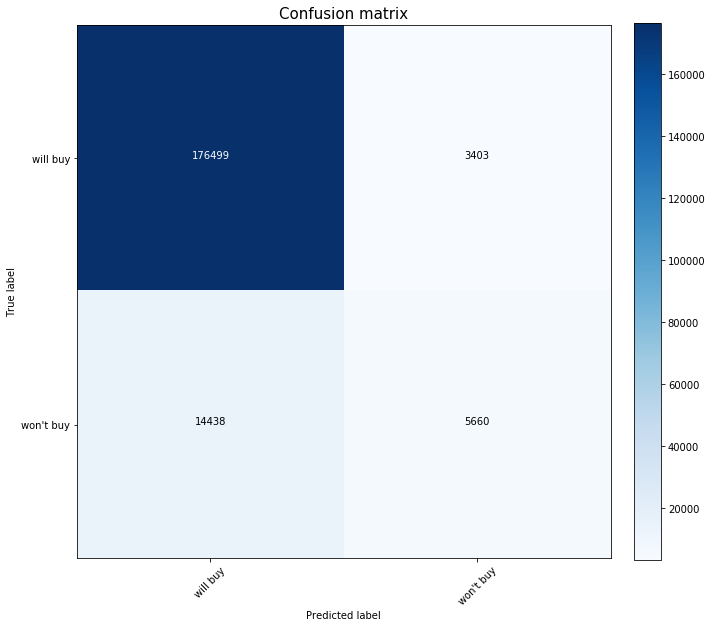

In [13]:
import itertools
from sklearn.metrics import accuracy_score, confusion_matrix
def plot_confusion_matrix(truth, pred, classes, normalize=False, title=''):
    cm = confusion_matrix(truth, pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix', size=15)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.tight_layout()
    
plot_confusion_matrix(target, train_oof>0.5, ['will buy', 'won\'t buy'])